In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [2]:
# Parameters for tunning

BASE_IMG_FOLDER = './VC_2425_Project_public/images/'

# Parameters for the image processing
SHOW_DEBUG_IMGS = "NONE" # ["LINES", "WARP", "ALL", "NONE"]
CORNER_HORSE_TEMPLATE_PATH = "./cornerHorse_templates/"
SAVE_DEBUG_IMGS = False

In [3]:
# Load the images for the corner horses and store them in a list
CORNER_HORSES_TEMPLATES = []
for filename in os.listdir(CORNER_HORSE_TEMPLATE_PATH):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(CORNER_HORSE_TEMPLATE_PATH, filename))
        CORNER_HORSES_TEMPLATES.append(img)
    else:
        continue

In [4]:
def show_original_and_gray(image_path):
    original_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Wood removal by color thresholding (targeting brown/wooden colors)
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    
    # Define range for brown/wooden colors in HSV
    lower_brown = np.array([2, 11, 11])
    upper_brown = np.array([60, 255, 255]) 
    
    # Create mask for wood
    wood_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    
    # Invert the mask to keep non-wood parts
    wood_mask_inv = cv2.bitwise_not(wood_mask)
    
    # Apply the mask to the original image
    no_wood_img = cv2.bitwise_and(original_img, original_img, mask=wood_mask_inv)
    
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(no_wood_img, cv2.COLOR_BGR2GRAY)

    # Display images to show the process
    if SHOW_DEBUG_IMGS == "ALL":
        plt.figure(figsize=(10, 5))

        # Original image - left
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.title('Original RGB Image')

        # Final grayscale image - right
        plt.subplot(1, 2, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
        plt.title('Without Wood Grayscale Image')

        plt.tight_layout()
        plt.show()

    return original_img, gray_img

In [5]:
def preprocess_image(gray_img, blur_kernel_size=17, intensity_factor=1.3, laplacian_kernel_size=3):
    blurred = cv2.GaussianBlur(gray_img, (blur_kernel_size, blur_kernel_size), 0)
    adjusted_img = cv2.convertScaleAbs(blurred, alpha=intensity_factor, beta=0)

    # Morphological opening to remove small details like pieces
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opened = cv2.morphologyEx(adjusted_img, cv2.MORPH_OPEN, kernel)

    laplacian = cv2.Laplacian(opened, cv2.CV_64F, ksize=laplacian_kernel_size)
    laplacian = cv2.convertScaleAbs(laplacian)

    # OTSU + optional manual offset to suppress weak edges
    otsu_thresh_val, _ = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary_img = cv2.threshold(laplacian, otsu_thresh_val + 20, 255, cv2.THRESH_BINARY)

    return binary_img

In [6]:
def detect_lines(binary_img, min_line_length=50, max_line_gap=50):
    # Canny edge detection with lower threshold
    canny_image = cv2.Canny(binary_img, 50, 200)  # Tuning thresholds to capture better edges

    # Use dilation to reinforce edges
    kernel = np.ones((13, 13), np.uint8)
    dilation_image = cv2.dilate(canny_image, kernel, iterations=1)
    
    # Hough Lines transform for line detection
    lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Create an image to store the detected lines
    black_image = np.zeros_like(dilation_image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
    return black_image

In [7]:
def remove_noise_components(line_img, min_area=1000, keep_largest=True):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(line_img, connectivity=8)
    
    # Create a black image to store the final result
    final_image = np.zeros_like(line_img)
    
    if keep_largest:
        # Get the areas of all components (ignoring the background)
        areas = stats[1:, cv2.CC_STAT_AREA]
        
        # Find the label of the largest component
        max_label = 1 + np.argmax(areas)
        
        # Keep only the largest component
        final_image[labels == max_label] = 255
    else:
        # If not keeping only the largest component, keep components above the min_area threshold
        for label in range(1, num_labels):
            area = stats[label, cv2.CC_STAT_AREA]
            if area >= min_area:
                final_image[labels == label] = 255

    if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES"):
        plt.subplot(1, 3, 1)
        plt.title("Only Board Lines (Filtered)", fontsize=12)
        plt.imshow(final_image, cmap="gray")
        plt.axis('off')

    return final_image


In [8]:
def find_chessboard_contour(line_img):
    contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    if contours:
        return contours[0]
    return None

In [9]:
def order_corners(corners):
    sorted_by_y = sorted(corners, key=lambda p: p[1])
    top_two = sorted(sorted_by_y[:2], key=lambda p: p[0])
    bottom_two = sorted(sorted_by_y[2:], key=lambda p: p[0])
    return np.array([top_two[0], top_two[1], bottom_two[0], bottom_two[1]], dtype="float32")

In [10]:
def warp_chessboard(gray_img, original_img, contour, board_size=800):
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx_corners = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx_corners) == 4:
        corners = np.squeeze(approx_corners)
        ordered_corners = order_corners(corners)
        dst_corners = np.array([
            [0, 0], [board_size - 1, 0],
            [0, board_size - 1], [board_size - 1, board_size - 1]
        ], dtype="float32")
        matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
        warped_board = cv2.warpPerspective(gray_img, matrix, (board_size, board_size))
        
        # Also warp the original RGB image
        warped_original = cv2.warpPerspective(original_img, matrix, (board_size, board_size))
        warped_original_rgb = cv2.cvtColor(warped_original, cv2.COLOR_BGR2RGB)
        
        if (SHOW_DEBUG_IMGS == "ALL" or SHOW_DEBUG_IMGS == "LINES" or SHOW_DEBUG_IMGS == "WARP"):
            plt.subplot(1, 3, 2)
            plt.title("Warped Chessboard (Grayscale)", fontsize=12)
            plt.imshow(warped_board, cmap="gray")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Warped Chessboard (Original)", fontsize=12)
            plt.imshow(warped_original_rgb)
            plt.axis('off')
            
        # Return the warp matrix as well to allow for reverting the transform
        return warped_board, warped_original_rgb, matrix, ordered_corners, dst_corners
    else:
        print("Error: Did not find exactly 4 corners!")
        return None, None, None, None, None

In [11]:
def process_chessboard_image(image_path):
    original_img, gray_img = show_original_and_gray(image_path)
    otsu_binary = preprocess_image(gray_img)
    line_img = detect_lines(otsu_binary)
    clean_line_img = remove_noise_components(line_img)
    contour = find_chessboard_contour(clean_line_img)
    if contour is not None:
        return warp_chessboard(gray_img, original_img, contour)
    else:
        print("Chessboard contour not found!")
        return None

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_grid_lines(image_rgb, show_lines=True, edge_threshold=20):
    height, width = image_rgb.shape[:2]

    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (17, 13), 0)

    edges = cv2.Canny(blurred, 50, 150)
    edges = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)

    # if show_lines:
    #     plt.figure(figsize=(12, 6))
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(image_rgb)
    #     plt.title("Original Image")
    #     plt.axis("off")
        
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(edges, cmap='gray')
    #     plt.title("Dilated Canny Edges")
    #     plt.axis("off")
    #     plt.tight_layout()
    #     plt.show()

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=10)
    
    if lines is None:
        print("No lines found")
        return [], []

    horizontal_lines = []
    vertical_lines = []

    for x1, y1, x2, y2 in lines[:, 0]:
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle) < 10:
            horizontal_lines.append((x1, y1, x2, y2))
        elif abs(angle - 90) < 10 or abs(angle + 90) < 10:
            vertical_lines.append((x1, y1, x2, y2))

    # if show_lines:
    #     hough_image = image_rgb.copy()
    #     for x1, y1, x2, y2 in horizontal_lines + vertical_lines:
    #         cv2.line(hough_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    #     plt.figure(figsize=(8, 8))
    #     plt.imshow(hough_image)
    #     plt.title("Detected Lines (HoughLinesP)")
    #     plt.axis("off")
    #     plt.show()

    def merge_line_coords(lines, axis='y', threshold=15):
        if not lines:
            return []
        coords = [int((y1 + y2) / 2) if axis == 'y' else int((x1 + x2) / 2) for x1, y1, x2, y2 in lines]
        coords = sorted(coords)
        merged = []
        current = coords[0]
        for val in coords[1:]:
            if abs(val - current) < threshold:
                current = int((current + val) / 2)
            else:
                merged.append(current)
                current = val
        merged.append(current)
        return merged

    merged_horizontal = merge_line_coords(horizontal_lines, axis='y')
    merged_vertical = merge_line_coords(vertical_lines, axis='x')

    # Remove lines too close to image edges
    merged_horizontal = [y for y in merged_horizontal if edge_threshold < y < (height - edge_threshold)]
    merged_vertical = [x for x in merged_vertical if edge_threshold < x < (width - edge_threshold)]

    if show_lines:
        merged_image = image_rgb.copy()
        for y in merged_horizontal:
            cv2.line(merged_image, (0, y), (merged_image.shape[1], y), (255, 0, 0), 3)
        for x in merged_vertical:
            cv2.line(merged_image, (x, 0), (x, merged_image.shape[0]), (255, 0, 0), 3)

        plt.figure(figsize=(8, 8))
        plt.imshow(merged_image)
        plt.title("Filtered Merged Grid Lines")
        plt.axis("off")
        plt.show()

    return merged_horizontal, merged_vertical

In [13]:
def find_horse_template_matching(image_rgb, image_name=None):
    img_rgb = image_rgb.copy()
    height, width = img_rgb.shape[:2]
    
    best_match_val = -np.inf
    best_match_loc = None
    best_template_shape = None
    best_template_index = None

    for idx, template_rgb in enumerate(CORNER_HORSES_TEMPLATES):
        if template_rgb is None:
            print(f"Template at index {idx} is None.")
            continue

        h, w = template_rgb.shape[:2]
        
        # Template matching
        res = cv2.matchTemplate(img_rgb, template_rgb, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        
        if max_val > best_match_val:
            best_match_val = max_val
            best_match_loc = max_loc
            best_template_shape = (h, w)
            best_template_index = idx

    print(f"Best match index: {best_template_index} with score {best_match_val:.2f}")
    if best_match_val >= 0.65:
        top_left = best_match_loc
        h, w = best_template_shape
        bottom_right = (top_left[0] + w, top_left[1] + h)

        # Draw match rectangle
        cv2.rectangle(img_rgb, top_left, bottom_right, (0, 255, 0), 2)

        # Center of match
        center_x = top_left[0] + w // 2
        center_y = top_left[1] + h // 2

        # Determine closest corner
        corners = [
            ("top-left", (0, 0)),
            ("top-right", (width, 0)),
            ("bottom-left", (0, height)),
            ("bottom-right", (width, height))
        ]
        
        closest_corner = min(corners, key=lambda c: 
            np.sqrt((center_x - c[1][0])**2 + (center_y - c[1][1])**2))

        # Print image name and closest corner
        if image_name:
            print(f"{image_name}: {closest_corner[0]}")
        else:
            print(f"Closest corner: {closest_corner[0]}")
            
        return closest_corner[0]
    else:
        if image_name:
            print(f"{image_name}: No good match found.")
        else:
            print("No good match found.")
        return None

In [14]:
# Create output directory if it doesn't exist
output_dir = './chessboard_outputs/'
os.makedirs(output_dir, exist_ok=True)

# Process all images in the images folder
# image_files = [os.path.join(BASE_IMG_FOLDER, f) for f in os.listdir(BASE_IMG_FOLDER) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Define specific image files to process
image_filenames_failed = [
    "G000_IMG062.jpg"
    # "G006_IMG119.jpg",
    # "G091_IMG053.jpg",
]

# Create full paths for each image file
image_files = [os.path.join(BASE_IMG_FOLDER, filename) for filename in image_filenames_failed]

# Process each image
failed_images = []
rotations = {
    "top-left": 90,
    "top-right": 180,
    "bottom-left": 0,
    "bottom-right": -90
}

successful_images = {}

for image_path in image_files:
    filename = os.path.basename(image_path)
    print(f"Processing {filename}")

    if (SHOW_DEBUG_IMGS != "NONE"):
        plt.figure(figsize=(16, 8))

    warped, warped_original_rgb, matrix, ordered_corners, dst_corners = process_chessboard_image(image_path)

    if warped is not None:
        # Detect orientation
        closest_corner = find_horse_template_matching(warped_original_rgb, filename)
        rotation_angle = rotations.get(closest_corner, 0)

        # Apply rotation to both warped images
        def rotate_image(image, angle):
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        warped_rotated = rotate_image(warped, rotation_angle)
        warped_original_rgb_rotated = rotate_image(warped_original_rgb, rotation_angle)

        successful_images[filename] = {
            'warped': warped_rotated,
            'warped_original_rgb': warped_original_rgb_rotated,
            'matrix': matrix,
            'ordered_corners': ordered_corners,
            'dst_corners': dst_corners
        }

    else:
        failed_images.append(filename)

    if (SHOW_DEBUG_IMGS != "NONE"):
        plt.tight_layout(pad=3.0)
        subplot_path = os.path.join(output_dir, f"subplots_{filename.split('.')[0]}.png")
        if SAVE_DEBUG_IMGS:
            plt.savefig(subplot_path, dpi=300, bbox_inches='tight')
        print(f"Saved subplots to {subplot_path}")
        plt.show()

# Summary
print("\nImages where chessboard detection failed:")
for failed_image in failed_images:
    print(failed_image)

print(f"\nSuccessfully processed {len(image_files) - len(failed_images)}/{len(image_files)} images")
print(f"Subplot images saved to: {os.path.abspath(output_dir)}")

Processing G000_IMG062.jpg
Best match index: 0 with score 0.92
G000_IMG062.jpg: bottom-left

Images where chessboard detection failed:

Successfully processed 1/1 images
Subplot images saved to: c:\Users\Cristiano\Desktop\Faculdade\2º semestre\VC\project\VC_project\chessboard_outputs


In [15]:
import matplotlib.pyplot as plt

files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

for k, v in successful_images.items():
    board_size = v['warped_original_rgb'].shape[0]
    crop_margin = int(board_size * 0.07)

    cropped_board = v['warped_original_rgb'][crop_margin:board_size - crop_margin,
                                             crop_margin:board_size - crop_margin]
    v['cropped_board'] = cropped_board
    h_lines, v_lines = detect_grid_lines(cropped_board, show_lines=False)

    if len(h_lines) != 7 or len(v_lines) != 7:
        print(f"Not enough grid lines detected in {k}.")
        continue

    height, width = cropped_board.shape[:2]
    h_lines_full = [0] + sorted(h_lines) + [height]
    v_lines_full = [0] + sorted(v_lines) + [width]

    squares = []

    for i in range(8):  # rows (0 = top = rank 8)
        for j in range(8):  # columns (0 = left = file a)
            y1, y2 = h_lines_full[i], h_lines_full[i + 1]
            x1, x2 = v_lines_full[j], v_lines_full[j + 1]
            square = cropped_board[y1:y2, x1:x2]
            rank = 8 - i
            file = files[j]
            label = f"{file}{rank}"
            squares.append({
                "position": (i, j),
                "label": label,
                "image": square
            })

    v['squares'] = squares

### Removing shadowns from pieces

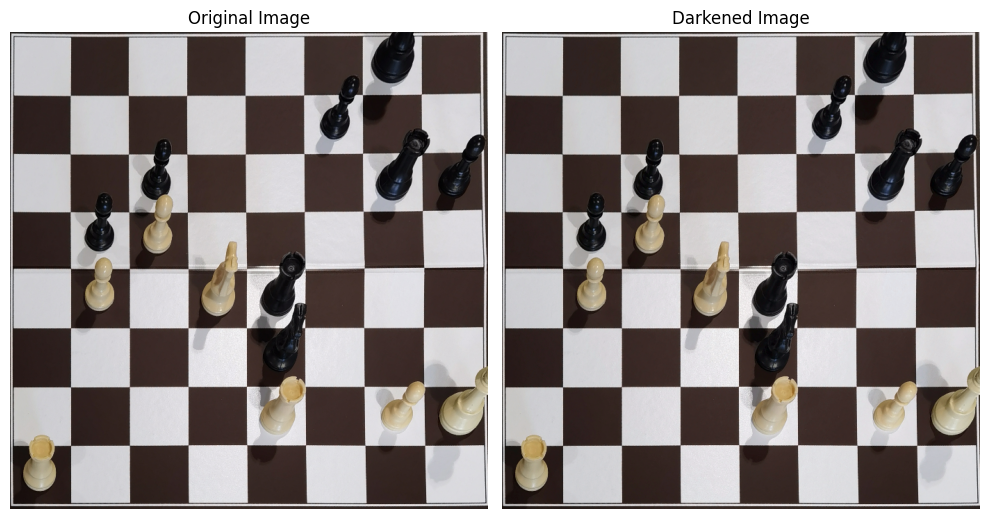

In [31]:
import matplotlib.pyplot as plt

for k, v in successful_images.items():
    board_size = v['warped_original_rgb'].shape[0]
    crop_margin = int(board_size * 0.07)

    # Crop the board
    cropped_board = v['warped_original_rgb'][crop_margin:board_size - crop_margin,
                                             crop_margin:board_size - crop_margin]
    v['cropped_board'] = cropped_board

    # Apply darkening to the lighter parts of the image
    darkened_image = lighten_greyer_areas(cropped_board)

    # Store the processed image
    v['darkened_image'] = darkened_image

    # Display the first image's results
    if k == list(successful_images.keys())[0]:
        plt.figure(figsize=(10, 6))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(cropped_board)
        plt.title('Original Image')
        plt.axis('off')

        # Darkened image
        plt.subplot(1, 2, 2)
        plt.imshow(darkened_image)
        plt.title('Darkened Image')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


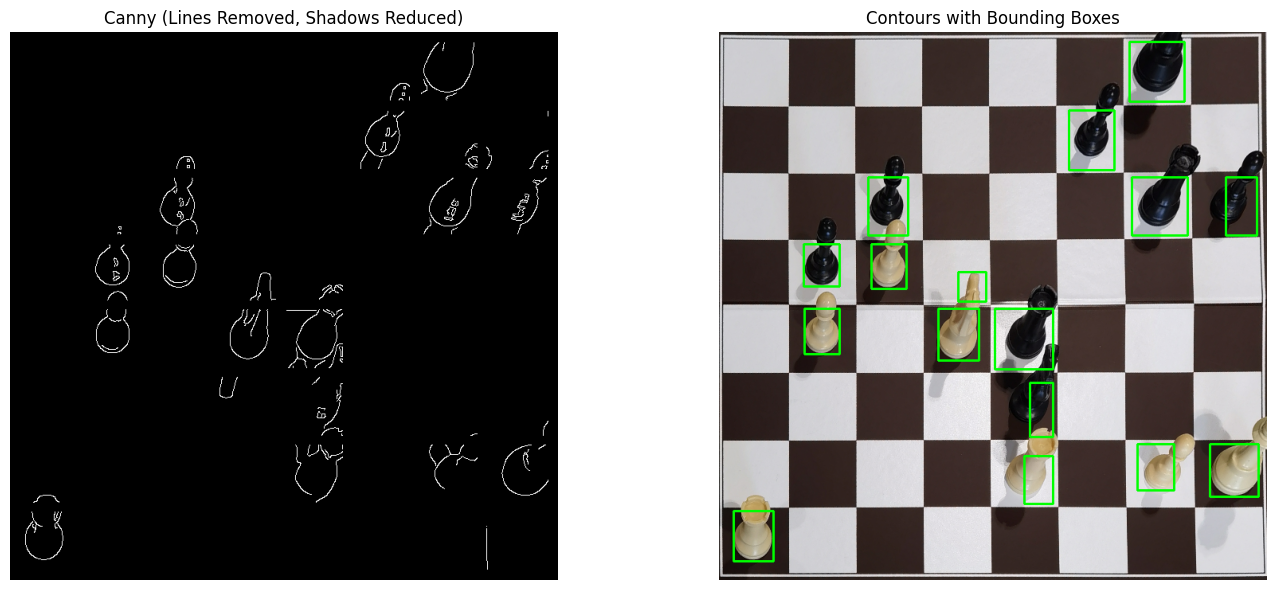

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_grid_lines(cropped_board, show_lines=False):
    """
    Detect horizontal and vertical grid lines from the image.
    Filters out lines that don't fit the expected grid structure.
    """
    # Convert to grayscale and apply Gaussian blur to reduce noise
    gray = cv2.cvtColor(cropped_board, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    
    h_lines, v_lines = [], []

    # Check if the lines are horizontal or vertical and filter out short or skewed lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Check if the line is nearly horizontal
            if abs(y2 - y1) < abs(x2 - x1):  # Line is mostly horizontal
                # Further check if the line is near horizontal (i.e., y1 ≈ y2)
                if abs(y2 - y1) < 10:  # Tolerance for horizontal lines
                    h_lines.append(y1)
            
            # Check if the line is nearly vertical
            elif abs(x2 - x1) < abs(y2 - y1):  # Line is mostly vertical
                # Further check if the line is near vertical (i.e., x1 ≈ x2)
                if abs(x2 - x1) < 10:  # Tolerance for vertical lines
                    v_lines.append(x1)

    # Optionally display the detected lines
    if show_lines:
        img_lines = np.copy(cropped_board)
        for y in h_lines:
            cv2.line(img_lines, (0, y), (img_lines.shape[1], y), (0, 255, 0), 2)
        for x in v_lines:
            cv2.line(img_lines, (x, 0), (x, img_lines.shape[0]), (0, 255, 0), 2)
        
        plt.imshow(img_lines)
        plt.title("Detected Grid Lines")
        plt.axis('off')
        plt.show()

    return h_lines, v_lines

for k, v in successful_images.items():
    board_size = v['warped_original_rgb'].shape[0]
    crop_margin = int(board_size * 0.07)

    # Crop the board
    cropped_board = v['warped_original_rgb'][crop_margin:board_size - crop_margin,
                                             crop_margin:board_size - crop_margin]
    v['cropped_board'] = cropped_board

    # Detect grid lines
    h_lines, v_lines = detect_grid_lines(cropped_board, show_lines=False)

    # Convert to grayscale and blur to reduce shadows
    gray = cv2.cvtColor(cropped_board, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Helps smooth out shadows


    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Remove grid lines by drawing thicker black lines (only horizontal and vertical grid lines)
    line_thickness = 10
    for y in h_lines:
        cv2.line(edges, (0, y), (edges.shape[1], y), 0, line_thickness)
    for x in v_lines:
        cv2.line(edges, (x, 0), (x, edges.shape[0]), 0, line_thickness)

    # Dilation to emphasize remaining edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Find contours on the dilated image
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours
    contour_image = np.copy(cropped_board)


    min_width = 28
    min_height = 30
    # Draw contours on the image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= min_width and h >= min_height:
            cv2.rectangle(contour_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Store results
    v['canny_lines_removed'] = edges
    v['dilated_edges'] = dilated
    v['contour_image'] = contour_image

    # Display for the first board
    if k == list(successful_images.keys())[0]:
        plt.figure(figsize=(15, 6))

        # Canny edges image
        plt.subplot(1, 2, 1)
        plt.imshow(edges, cmap='gray')
        plt.title("Canny (Lines Removed, Shadows Reduced)")
        plt.axis('off')

        # Contour image with bounding boxes
        plt.subplot(1, 2, 2)
        plt.imshow(contour_image)
        plt.title("Contours with Bounding Boxes")
        plt.axis('off')

        plt.tight_layout()
        plt.show()